# IMPORT LIBRARIES

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image

from torchvision import models
import torchvision.transforms as transforms 

from SIBI_classifier.logger.logging import log_manager
from SIBI_classifier.configuration.configuration import ConfigurationManager
from SIBI_classifier.exception import SIBIClassificationException

# SETUP CONSTANTS
In this section, we will define some constants that are important for data processing and model training.
These constants will help us set the dataset folder path, the extension pattern of the image files to be collected, and which folders to access.
Later, these constants will be used in various parts of the code.

In [2]:
CONFIG = ConfigurationManager()
DATA_PREPROCESSING_CONFIG = CONFIG.get_data_preprocessing_config()
MODEL_TRAINER = CONFIG.get_model_trainer_config()

PREDICTION_LOGGER = log_manager.setup_logger("PredictionLogger")
IMAGE_PROCESSING_LOGGER = log_manager.setup_logger("image_processing_logger")
DATA_PREPROCESSING_LOGGER = log_manager.setup_logger("DataPreprocessingLogger")

COLOR_TEXT = "yellow"

[ 2024-12-07 08:10:33 ] create_directories_logger - INFO - created directory at: artifacts


[ 2024-12-07 08:10:33 ] create_directories_logger - INFO - created directory at: artifacts/<model_name>/results/model


# PREPARING DATA PREDICTION

## Load Data From Folders

### function

In [3]:
def initialize_hands(
        max_hands=1, 
        static_mode=True, 
        min_detect_conf=0.2, 
        min_track_conf=0.2
    ):
    
    """Inisialisasi MediaPipe Hands."""
    return mp.solutions.hands.Hands(
        max_num_hands=max_hands,
        static_image_mode=static_mode,
        min_detection_confidence=min_detect_conf,
        min_tracking_confidence=min_track_conf,
    )

In [4]:
def draw_landmarks_on_image(
        image, 
        landmarks, 
        hands_module, 
        drawing_spec, 
        connection_spec
    ):
    
    """Draw landmarks on the image using MediaPipe."""
    mp_drawing = mp.solutions.drawing_utils
    for hand_landmarks in landmarks:
        mp_drawing.draw_landmarks(
            image,
            hand_landmarks,
            hands_module.HAND_CONNECTIONS,
            landmark_drawing_spec=drawing_spec,
            connection_drawing_spec=connection_spec,
        )

In [5]:
def get_hand_bounding_box(
        landmarks, 
        image_shape, 
        offset
    ):
    
    """Calculate the bounding box for the hand based on the landmarks."""
    points = np.array([
        [landmark.x * image_shape[1], landmark.y * image_shape[0]] 
        for landmark in landmarks.landmark
    ])
    x, y, w, h = cv2.boundingRect(points.astype("float32"))
    return max(0, x - offset), max(0, y - offset), w + 2 * offset, h + 2 * offset

In [6]:
def crop_and_resize(
        image, 
        bbox, 
        target_size
    ):
    
    """Cut the image according to the bounding box and resize it."""
    x, y, w, h = bbox
    cropped_image = image[y:y + h, x:x + w]
    if cropped_image.size == 0:
        return None

    resized_image = cv2.resize(cropped_image, (target_size, target_size))
    rgb_white_image = np.ones((target_size, target_size, 3), dtype=np.uint8) * 255
    rgb_white_image[:target_size, :target_size] = resized_image
    return rgb_white_image

In [7]:
def process_image(
		file_path, 
		hands_processor, 
		target_size=224, 
		offset=50
	):
	
	"""Process images to detect hands and landmarks."""
	mp_drawing = mp.solutions.drawing_utils	

	image = cv2.imread(file_path)
	if image is None:
		raise FileNotFoundError(f"Image not found: {file_path}")

	rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	results = hands_processor.process(rgb_image)

	if not results.multi_hand_landmarks:
		print("Hand is not detected.")
		return None

	# Gambar landmark pada gambar asli
	draw_landmarks_on_image(
		rgb_image, 
		results.multi_hand_landmarks, 
		mp.solutions.hands, 
		mp_drawing.DrawingSpec(color=(0, 0, 0)),
		mp_drawing.DrawingSpec(color=(255, 255, 255)),
	)

	# Ambil bounding box untuk tangan pertama
	bbox = get_hand_bounding_box(results.multi_hand_landmarks[0], rgb_image.shape, offset)
	processed_image = crop_and_resize(rgb_image, bbox, target_size)
	return processed_image


In [8]:
# Functional API - Define the forward pass
class TransferLearningModel(torch.nn.Module):
	def __init__(
			self, 
			base_model: torch.nn.Module=None, 
		) -> None:
        
		super(TransferLearningModel, self).__init__()

		length_label_list = len(DATA_PREPROCESSING_CONFIG.label_list)
		num_classes = 1 if length_label_list == 2 else length_label_list

		self.base_model = base_model
		self.base_model.features = base_model.features  # Feature extractor
		self.global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))

		# Define a new fully cotorch.nnected layer
		self.fc = torch.nn.Linear(base_model.classifier.in_features, num_classes)

		# Activation based on number of classes
		self.activation = torch.nn.Sigmoid() if num_classes == 1 else torch.nn.Softmax(dim=1)

	def forward(
			self, 
			x: torch.Tensor
		) -> torch.Tensor:
		
		# Pass through the feature extractor
		x = self.base_model.features(x)
		
		# Apply global average pooling
		x = self.global_avg_pool(x)
		x = torch.flatten(x, 1)  # Flatten the tensor
		
		# Pass through the classifier
		x = self.fc(x)

		# Apply activation
		x = self.activation(x)
		return x

In [9]:
class ImageProcessor:
	def __init__(
			self, 
			image_size: tuple=(224, 224),
			mean=(0, 0, 0), 
			std=(1, 1, 1),
			brightness: tuple=(0.5, 1.5),
			contrast: tuple=(0.5, 1.5),
			saturation: tuple=(0.5, 1.5),
			hue: tuple=(-0.5, 0.5),
			p: float=0.5,
		):

		self.image_size = image_size
		self.mean = mean
		self.std = std
		self.brightness = brightness
		self.contrast = contrast
		self.saturation = saturation
		self.hue = hue
		self.p = p
	
	def image_to_PIL(self) -> transforms.ToPILImage:
		IMAGE_PROCESSING_LOGGER.info(f"Normalizing image to {log_manager.color_text('0 to 1', COLOR_TEXT)}")
		return transforms.ToPILImage()

	def image_resizing(self) -> transforms.Resize:
		IMAGE_PROCESSING_LOGGER.info(f"Resizing image to {log_manager.color_text(self.image_size, COLOR_TEXT)}")
		return transforms.Resize(
			size=self.image_size[:2],
			interpolation=transforms.InterpolationMode.BILINEAR
		)

	def color_jitter(self) -> transforms.ColorJitter:
		IMAGE_PROCESSING_LOGGER.info(
			f"Color jittering with "
			f"brightness {log_manager.color_text(self.brightness, COLOR_TEXT)}, " 
			f"contrast {log_manager.color_text(self.contrast, COLOR_TEXT)}, " 
			f"saturation {log_manager.color_text(self.saturation, COLOR_TEXT)}, "
			f"hue {log_manager.color_text(self.hue, COLOR_TEXT)}"
		)
		return transforms.ColorJitter(
			brightness=self.brightness, 
			contrast=self.contrast, 
			saturation=self.saturation, 
			hue=self.hue
		)

	def hFlip(self) -> transforms.RandomHorizontalFlip:
		IMAGE_PROCESSING_LOGGER.info(f"Horizontal Flipping with probability {log_manager.color_text(self.p, COLOR_TEXT)}")
		return transforms.RandomHorizontalFlip(p=self.p)

	def vFlip(self) -> transforms.RandomVerticalFlip:
		IMAGE_PROCESSING_LOGGER.info(f"Vertical Flipping with probability {log_manager.color_text(self.p, COLOR_TEXT)}")
		return transforms.RandomVerticalFlip(p=self.p)
	
	def image_normalization(self) -> transforms.Normalize:
		IMAGE_PROCESSING_LOGGER.info(f"Normalizing image with mean {log_manager.color_text(self.mean, COLOR_TEXT)} and std {log_manager.color_text(self.std, COLOR_TEXT)}")
		return transforms.Normalize(mean=self.mean, std=self.std)

	def image_to_tensor(self) -> transforms.ToTensor:
		IMAGE_PROCESSING_LOGGER.info(f"Normalizing image to {log_manager.color_text('0 to 1', COLOR_TEXT)}")
		return transforms.ToTensor()

In [10]:
PREDICTION_LOGGER.info("Loading pre-trained base model...")
# Pre-trained base model
base_model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

# Freeze the base model layers
for param in base_model.parameters():
    param.requires_grad = False

[ 2024-12-07 08:10:33 ] PredictionLogger - INFO - Loading pre-trained base model...


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransferLearningModel(base_model)
model.load_state_dict(
    state_dict=torch.load(
		f=MODEL_TRAINER.model_file_path,
		weights_only=True,
	),
    strict=True
)
model = model.to(device)

In [12]:
# for name, param in model.named_parameters():
# 	print(name, param.device)

In [13]:
DATA_PREPROCESSING_LOGGER.info(f"Creating image processor...")
image_processor = ImageProcessor(
    image_size=DATA_PREPROCESSING_CONFIG.img_size[:2],
	mean=DATA_PREPROCESSING_CONFIG.mean, 
	std=DATA_PREPROCESSING_CONFIG.std,
    brightness=DATA_PREPROCESSING_CONFIG.brightness, 
    contrast=DATA_PREPROCESSING_CONFIG.contrast,
    saturation=DATA_PREPROCESSING_CONFIG.saturation,
    hue=DATA_PREPROCESSING_CONFIG.hue,
    p=DATA_PREPROCESSING_CONFIG.p,
)

[ 2024-12-07 08:10:39 ] DataPreprocessingLogger - INFO - Creating image processor...


I0000 00:00:1733533910.701906    1856 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733533910.730444    2935 gl_context.cc:357] GL version: 3.0 (OpenGL ES 3.0 Mesa 24.0.9-0ubuntu0.2), renderer: D3D12 (Intel(R) UHD Graphics 620)
W0000 00:00:1733533910.776217    2929 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733533910.807263    2933 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[ 2024-12-07 08:11:50 ] image_processing_logger - INFO - Normalizing image to 0 to 1


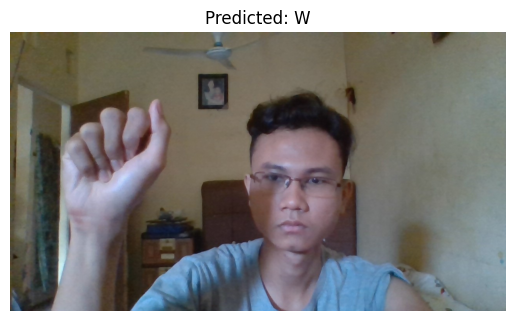

In [19]:
# file_path = "./artifacts/<model_name>/data_ingestion/SIBI_dataset/Test/image_C_(1723084152.1237173).jpg"
file_path = "../data/WIN_20241207_08_09_45_Pro.jpg"
hands = initialize_hands()
processed_image = process_image(file_path, hands, offset=50)
hands.close()

img = Image.open(file_path)

img_normalizer = image_processor.image_to_tensor()
test_img = img_normalizer(processed_image)

model.eval()
with torch.inference_mode():
	test_img = test_img.to(device)
	output = model(test_img.unsqueeze(0))
	_, predicted = torch.max(output, 1)

plt.imshow(img)
plt.title(f"Predicted: {DATA_PREPROCESSING_CONFIG.label_list[predicted.item()]}")
plt.axis("off")
plt.show()

In [15]:
log_manager.clean_log_file()